# Lipophilicity

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=78,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

DEBUG:jupyter_black:Using config from /home/andersle/src/moljourney/pyproject.toml
DEBUG:jupyter_black:config: {'line_length': 78, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

## Dowload raw data

In [3]:
from moljourney.tools import download_file

In [4]:
url = "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/Lipophilicity.csv"
download_file(url, "Lipophilicity.csv")

INFO:moljourney.tools:File Lipophilicity.csv exists - skipping download


'Lipophilicity.csv'

In [5]:
import pandas as pd

data = pd.read_csv("Lipophilicity.csv")
data.head()

,CMPD_CHEMBLID,exp,smiles
0,CHEMBL596271,3.54,Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14
1,CHEMBL1951080,-1.18,COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)...
2,CHEMBL1771,3.69,COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl
3,CHEMBL234951,3.37,OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(C...
4,CHEMBL565079,3.10,Cc1cccc(C[C@H](NC(=O)c2cc(nn2C)C(C)(C)C)C(=O)N...


## Create molecules

In [6]:
import moljourney

moljourney.__version__

'2023.1.dev1'

In [7]:
from moljourney.molecules import molecules_from_smiles

In [8]:
molecules, svgs = molecules_from_smiles(
    data["smiles"], svg=False, chunksize=10
)

  0%|          | 0/4200 [00:00<?, ?it/s]

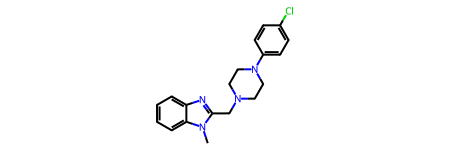

In [9]:
molecules[0]

## Descriptors

In [10]:
from moljourney.features.descriptors import (
    calculate_rdkit_descriptors,
)

/home/andersle/opt/pyenv/py3.10-moljourney/lib/python3.10/site-packages/mordred/InformationContent.py:53: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if dst is ():


In [74]:
descriptors_rdkit = calculate_rdkit_descriptors(molecules, chunksize=10)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

  0%|          | 0/4200 [00:00<?, ?it/s]

In [75]:
descriptors_rdkit.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,cnn(c)C,cnn(c)c,cnn1cnnn1,cnnc,cnnn(c)C,cnoc,cnsc,coc,csc,csn(c)C
0,5.976320,0.790958,5.976320,0.790958,0.728444,340.858,319.690,340.145474,124.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,13.847757,-4.060285,13.847757,0.083663,0.545587,494.591,468.383,494.118143,178.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,12.294248,-0.447454,12.294248,0.262241,0.807761,321.829,305.701,321.059027,110.0,0.0,...,0,0,0,0,0,0,0,0,1,0
3,12.966133,-1.063518,12.966133,0.046181,0.506650,419.890,401.746,419.070655,146.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,12.834652,-0.795707,12.834652,0.112199,0.747686,381.480,354.264,381.216475,148.0,0.0,...,1,0,0,0,0,0,0,0,0,0


In [76]:
descriptors_rdkit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4200 entries, 0 to 4199
Columns: 605 entries, MaxEStateIndex to csn(c)C
dtypes: float64(218), int64(387)
memory usage: 19.4 MB


In [102]:
from moljourney.features.fingerprints import get_fingerprints

In [104]:
fingerprints = get_fingerprints(molecules, method="rdkit")

DEBUG:moljourney.features.fingerprints:Using method "rdkit" for fingerprint.


Fingerprint:   0%|          | 0/4200 [00:00<?, ?it/s]

## Preprocess

### Preprocess: NaN/Inf/Missing numbers

In [105]:
from moljourney.plotting.mplplotting import missing_fraction

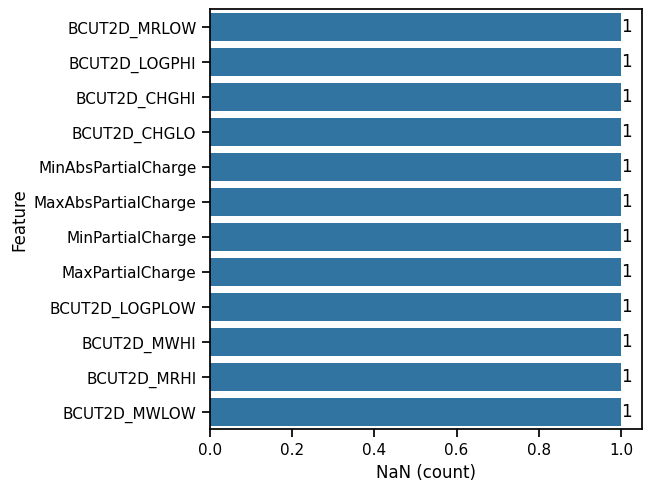

In [108]:
nan, fig = missing_fraction(
    descriptors_rdkit,
    sort="yes",
    show_all_features=False,
    use_feature_names=True,
    orient="horizontal",
    # rotation="vertical",
    fraction=None,  # 2 / 4200.0,
)

In [79]:
from moljourney.preprocess import preprocess_nan, count_nan

In [80]:
data2 = preprocess_nan(
    descriptors_rdkit, handle_nan="remove-samples", force_numeric=True
)

INFO:moljourney.preprocess:Removed 1 sample(s) with NaNs.
DEBUG:moljourney.preprocess:Columns removed: [1561]


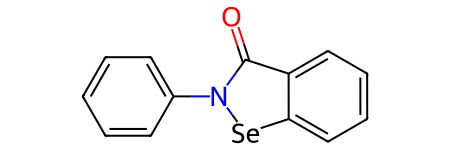

In [81]:
molecules[1561]

In [82]:
nan = count_nan(data2)
nan[nan["nan-count"] > 0]

,feature,nan-count,nan-fraction


In [83]:
from moljourney.preprocess import preprocess_variance

data3 = preprocess_variance(data2, threshold=0.1)

INFO:moljourney.preprocess:Removed 448 column(s) with low variance.
DEBUG:moljourney.preprocess:Column(s) removed: ['Asphericity', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO', 'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRLOW', 'BCUT2D_MWLOW', 'C#CC', 'C#Cc', 'C/C=C(\\C)C', 'C/C=C/C=C(/C)C(=O)NC1=CC(=O)ccC1=O', 'C/C=C/OC1(C)OccC1=O', 'C/C=C\\C(C)=O', 'C1CN2CCN=C2S1', 'C=C(C)C', 'C=C(C)C1=CC(=O)C=CC1', 'C=CC', 'CC#C/C=C/C', 'CC#CC', 'CC#N', 'CC(=N)NS(N)(=O)=O', 'CC(=O)C=C(C)C', 'CC(=O)C=C(C)C=CC', 'CC(=O)C=C(C)NC', 'CC(=O)N(C)C', 'CC(=O)N(C)C(C)=O', 'CC(=O)N(C)N(C)C(C)=O', 'CC(=O)NC', 'CC(=O)NC(C)=O', 'CC(=O)NC(N)=O', 'CC(=O)NO', 'CC(=O)NS(C)(=O)=O', 'CC(=O)NS(N)(=O)=O', 'CC(=O)O', 'CC(=O)OC', 'CC(=S)N(C)C', 'CC(C)=C(C)C', 'CC(C)=O', 'CC(N)=O', 'CC1(C)N=C(N)ccN1', 'CC1=C(C(=O)O)N2C(=O)C[C@H]2SC1', 'CC1=C(C)C(=O)C(C)=C(C)C1=O', 'CC1=C(C2=C(C)C(=O)ccC2=O)C(=O)ccC1=O', 'CC1=CC(=O)C=CC1', 'CC1=CC(=O)OC1', 'CC1=NCC(=O)N1C', 'CC1=NCCN1', 'CC1=NCCS1', 'CC1=NOS(=O)N1', 'CC1=NS(=O)(=O)ccN1', 'CC1NccS(=O)(=O)N

In [84]:
from moljourney.preprocess import preprocess_correlations

data4 = preprocess_correlations(data3, threshold=0.95)

INFO:moljourney.preprocess:Removed 34 correlated column(s)
DEBUG:moljourney.preprocess:Column(s) removed: ['CF', 'CO', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'ExactMolWt', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MolMR', 'NumSaturatedCarbocycles', 'NumValenceElectrons', 'PMI3', 'VSA_EState10', 'cCl', 'cN', 'cO', 'fr_COO2', 'fr_Nhpyrrole', 'fr_benzene', 'fr_phenol_noOrthoHbond']


In [85]:
data_merged = pd.concat(
    [data, data4],
    axis=1,
    join="inner",
)
data_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4199 entries, 0 to 4199
Columns: 126 entries, CMPD_CHEMBLID to csc
dtypes: float64(124), object(2)
memory usage: 4.1+ MB


In [86]:
skip = ("CMPD_CHEMBLID", "exp", "smiles")
variables = [i for i in data_merged.columns if i not in skip]

In [87]:
X_raw = data_merged[variables].to_numpy()
y_raw = data_merged["exp"].to_numpy()

### Preprocess: Scaling

In [88]:
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [89]:
scale_x = StandardScaler()
X = scale_x.fit_transform(X_raw)

## Dimension reduction

In [90]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_context("notebook")

### PCA

In [91]:
from moljourney.space import run_pca
from moljourney.plotting.mplplotting import style_pca_plot

In [92]:
pca, scores, _ = run_pca(X, scale=False)

In [93]:
def make_2d_plot(X, y, title=None):
    fig, ax = plt.subplots(constrained_layout=True)
    scat = ax.scatter(X[:, 0], X[:, 1], c=y, cmap="rocket")
    cbar = fig.colorbar(scat, ax=ax)
    cbar.set_label("y")
    if title is not None:
        ax.set_title(title, loc="left")
    sns.despine(fig=fig)
    return fig, ax

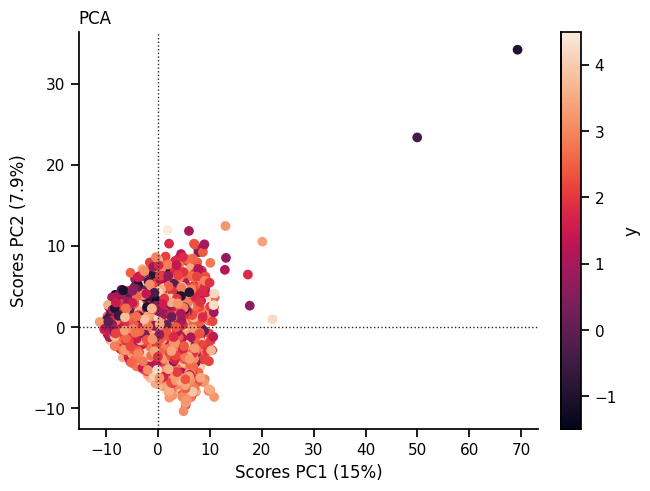

In [94]:
fig, ax = make_2d_plot(scores, y_raw, title="PCA")
style_pca_plot(ax, pca)

### T-SNE

In [41]:
from sklearn.manifold import TSNE

In [42]:
mapping_tsne = TSNE(n_components=2, perplexity=150, n_iter=1000)
X_tsne = mapping_tsne.fit_transform(X)

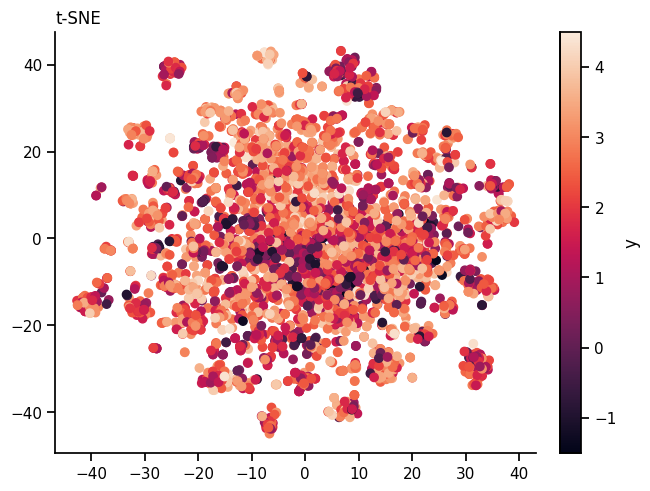

In [43]:
fig, ax = make_2d_plot(X_tsne, y_raw, title="t-SNE")

### Isomap

In [323]:
from sklearn.manifold import Isomap

In [324]:
mapping_isomap = Isomap()
X_isomap = mapping_isomap.fit_transform(X)

/home/andersle/opt/pyenv/py3.11-moljourney/lib/python3.11/site-packages/sklearn/manifold/_isomap.py:373: UserWarning: The number of connected components of the neighbors graph is 4 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/andersle/opt/pyenv/py3.11-moljourney/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/andersle/opt/pyenv/py3.11-moljourney/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/andersle/opt/pyenv/py3.11-moljourney/lib/python3.11/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_mat

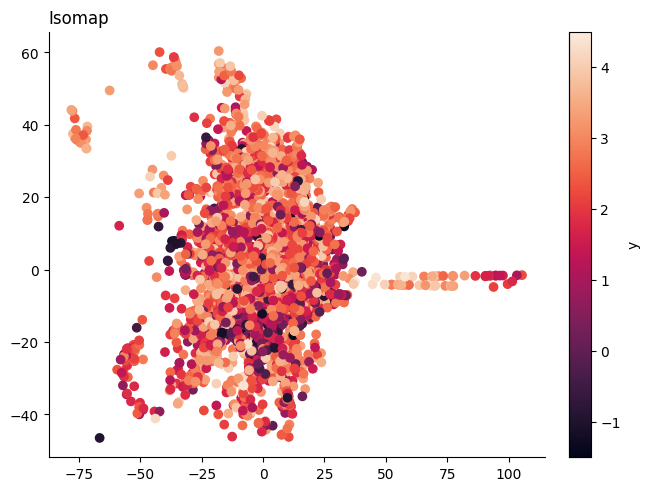

In [328]:
fig, ax = make_2d_plot(X_isomap, y_raw, title="Isomap")

### MDS

In [330]:
from sklearn.manifold import MDS

In [331]:
mapping_mds = MDS()
X_mds = mapping_mds.fit_transform(X)

/home/andersle/opt/pyenv/py3.11-moljourney/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


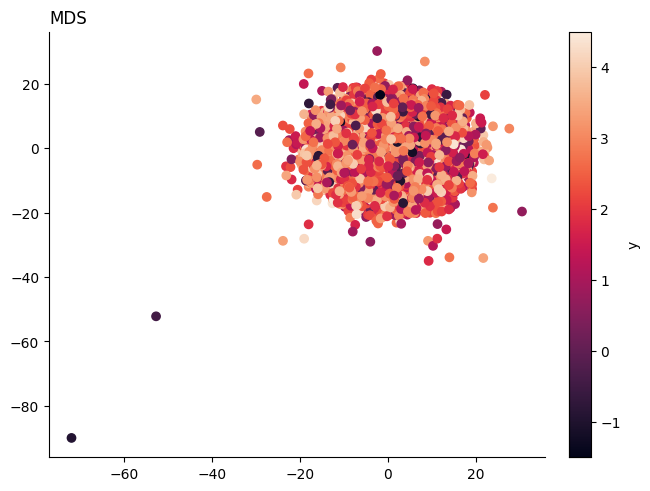

In [332]:
fig, ax = make_2d_plot(X_mds, y_raw, title="MDS")

### Spectral embedding

In [334]:
from sklearn.manifold import SpectralEmbedding

In [335]:
mapping_spectral = SpectralEmbedding()
X_spectral = mapping_spectral.fit_transform(X)

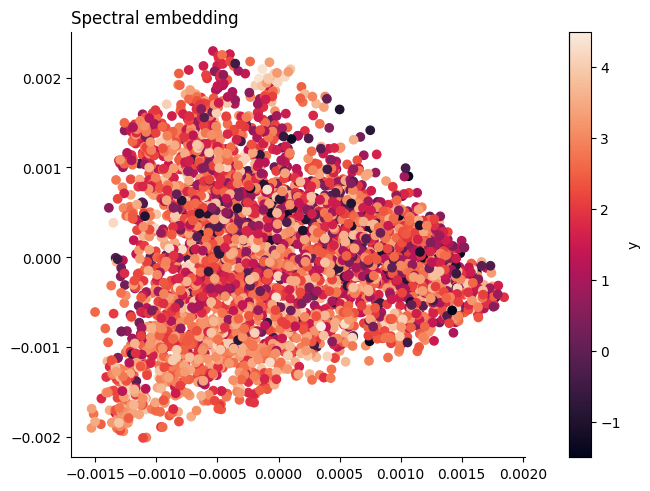

In [336]:
fig, ax = make_2d_plot(X_spectral, y_raw, title="Spectral embedding")

### UMAP, TriMAP, and PaCMAP

In [95]:
import umap
import trimap
import pacmap

In [96]:
mapping_umap = umap.UMAP(
    target_metric="regression", n_neighbors=25, min_dist=0.1
)
X_umap = mapping_umap.fit_transform(X)

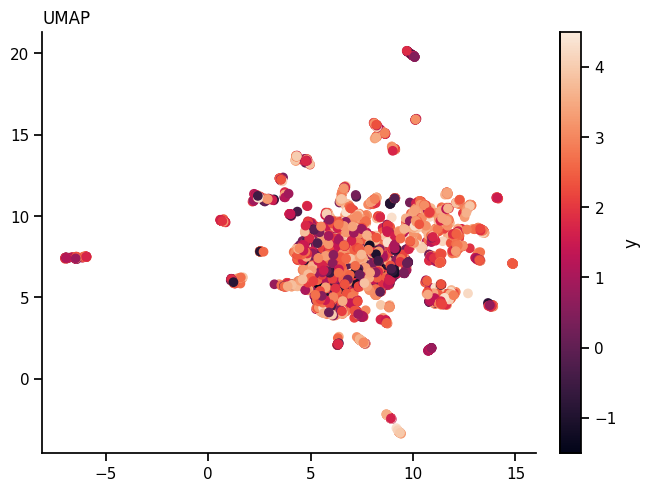

In [97]:
fig, ax = make_2d_plot(X_umap, y_raw, title="UMAP")

In [98]:
mapping_trimap = trimap.TRIMAP(n_inliers=50, n_outliers=15)
X_trimap = mapping_trimap.fit_transform(X)

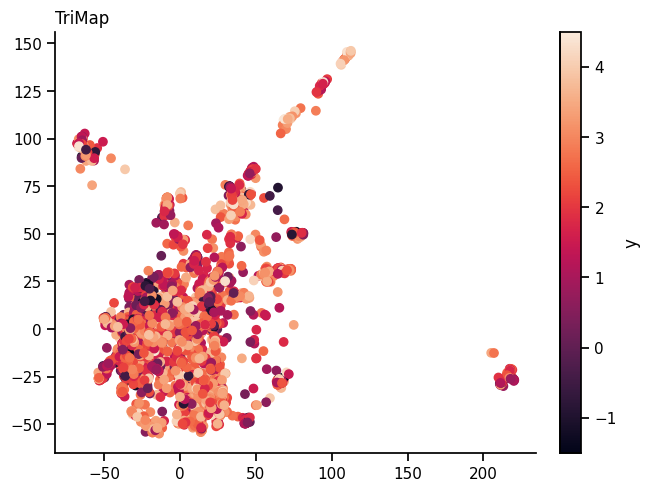

In [99]:
fig, ax = make_2d_plot(X_trimap, y_raw, title="TriMap")

In [100]:
mapping_pacmap = pacmap.PaCMAP()
X_pacmap = mapping_pacmap.fit_transform(X)

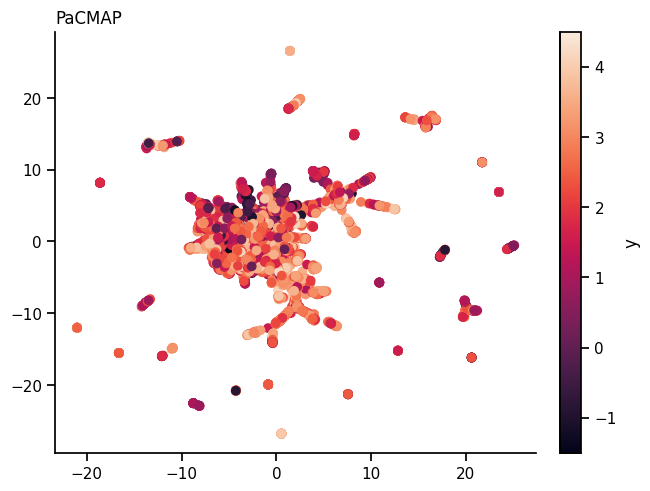

In [101]:
fig, ax = make_2d_plot(X_pacmap, y_raw, title="PaCMAP")